In [1]:
from ReebGraph import SequentialReebGraph
from tests.simulator import brownian_motion
import numpy as np
import matplotlib.pyplot as plt

In [13]:
TRAJECTORY_LENGTH = int(24 * 60 * 60 / 15)

trajectories = np.array(
    [brownian_motion(TRAJECTORY_LENGTH, 2) for i in range(30)]
    # [brownian_motion(30, 1) for i in range(4)]
)



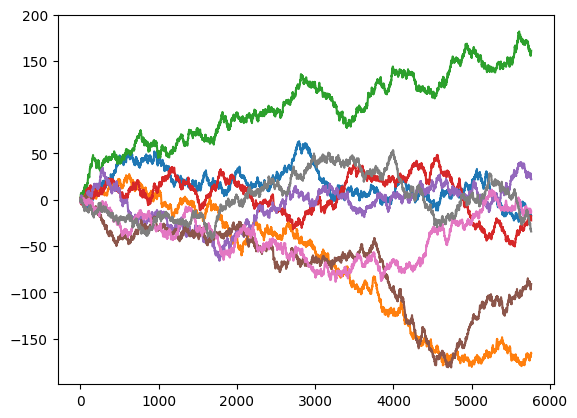

In [14]:
for _ in range(4):
    plt.plot(trajectories[_])

In [ ]:
reeb = SequentialReebGraph(epsilon=0)
for traj in trajectories:
    reeb.append_trajectory(traj)

# bundle_count = np.array([len(bundle) for bundle in reeb.bundle_trajectories])
# print(bundle_count)
# print(np.mean(bundle_count))


[10 12 18 ... 29 30 30]
29.881944444444443


In [16]:
reeb.build_graph()
print(reeb.nodes)

[(np.float64(0.0), np.float64(-0.7290284251192968), np.float64(-0.11587917398657299)), (np.float64(0.0), np.float64(0.40055842120399043), np.float64(-1.0135777802260937)), (np.float64(0.0), np.float64(0.8085927097816136), np.float64(0.7696965436476868)), (np.float64(0.0), np.float64(1.2566390033571901), np.float64(-3.203696139560178)), (np.float64(0.0), np.float64(0.29144282099463503), np.float64(2.045445891100034)), (np.float64(0.0), np.float64(1.5485477326315196), np.float64(0.04076481004338449)), (np.float64(0.0), np.float64(2.66733279620073), np.float64(0.10920643414545476)), (np.float64(0.0), np.float64(-2.3197799562383743), np.float64(-0.6257909012002065)), (np.float64(0.0), np.float64(-1.5812358137630875), np.float64(0.47756698965630634)), (np.float64(0.0), np.float64(-0.8531971336985384), np.float64(1.5112586571867608)), (np.float64(1.0), np.float64(0.12371153638965293), np.float64(2.2744577304371516)), (np.float64(1.0), np.float64(1.829569940176305), np.float64(-1.832198551686

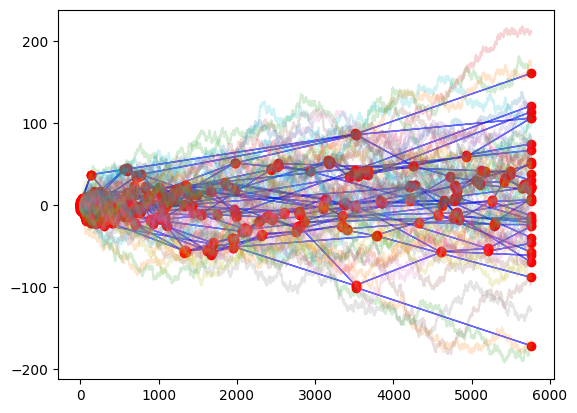

In [17]:
for edge in reeb.edges:
    dx = edge[1][0] - edge[0][0]
    dy = edge[1][1] - edge[0][1]
    plt.arrow(edge[0][0], edge[0][1], dx, dy, 
              head_width=0.5, head_length=0.6, fc='b', ec='b', 
              length_includes_head=True, alpha=0.6)

for node in reeb.nodes:
    plt.scatter(node[0], node[1], c='r')
    
for trajectory in trajectories:
    plt.plot(trajectory, alpha=0.2)